## What is this?
In 2, we didn't have good result for up/down prediction.
My tentative conclusion there was it's a nature of stock price prediction.

I'm going to see if the conclusiton align with this nikkei curve fitting problem.


In [1]:
import sys
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils.visualize_util import plot
from matplotlib.pyplot import show, plot
import pandas as pd
import numpy as np
import math
import random
random.seed(0)


Using TensorFlow backend.


In [2]:
df = pd.read_csv("../../dont_remove_data/nikkei.csv", header=None)
df


,0,1,2,3,4,5
0,19960401,21600,21870,21600,21650,21840
1,19960402,21620,21720,21580,21650,14860
2,19960403,21750,21830,21410,21510,25180
3,19960404,21540,21670,21490,21670,15460
4,19960405,21640,21830,21610,21820,13940
5,19960408,21640,21660,21430,21480,14720
6,19960409,21660,21900,21640,21880,26280
7,19960410,21840,21950,21790,21840,16460
8,19960411,21730,21820,21670,21740,16110
9,19960412,21740,21880,21630,21780,23210


In [39]:
# load
df = pd.read_csv("../../dont_remove_data/nikkei.csv", header=None)
df[1] = df[1].astype('float32')
df[1] = df[1].apply(lambda x: x / 10000)
prices = df[1]
print("prices.shape", prices.shape)


prices.shape (4853,)


In [111]:
# we use last 200 days data
nb_prev = 200

X = []
Y = []
# adjust Y to match the guidance
for i in range(len(prices)-nb_prev):
    X.append(prices.iloc[i:i+nb_prev].as_matrix())
    Y.append(prices.iloc[i+nb_prev])

X = np.array(X).reshape(-1, nb_prev, 1)
print("X.shape", X.shape)
Y = np.array(Y).reshape(-1, 1)
print("Y.shape", Y.shape)

X.shape (4653, 200, 1)
Y.shape (4653, 1)


In [112]:
# randomly split the data
test_size = 0.1
nb_train = int(round(len(X) * (1 - test_size)))
print("test_data_size", len(X) - nb_train)
shuffle = False

if shuffle:
    indices = np.random.permutation(X.shape[0])
    training_idx, test_idx = indices[:nb_train], indices[nb_train:]
    X_train, X_test = X[training_idx,:], X[test_idx,:]
    Y_train, Y_test = Y[training_idx,:], Y[test_idx,:]
else:
    X_train, X_test = X[:nb_train], X[nb_train:]
    Y_train, Y_test = Y[:nb_train], Y[nb_train:]    

print(X_train.shape)
print(Y_train.shape)
print("X_test.shape", X_test.shape)
print("Y_test.shape", Y_test.shape)

test_data_size 465
(4188, 200, 1)
(4188, 1)
X_test.shape (465, 200, 1)
Y_test.shape (465, 1)


In [113]:
in_out_neurons = 1
hidden_neurons = 300
length_of_sequences = nb_prev
model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))  
model.add(Dense(in_out_neurons))  
model.add(Activation("linear"))  
#    model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.compile(loss="mean_squared_error", optimizer="adam")

print(model.summary)


<bound method Container.summary of <keras.models.Sequential object at 0x12da9d7f0>>


In [114]:
version = 44
weights_dir = "/Users/higepon/Desktop/{0}-{1}".format(sys.argv[0], version)

def best_model_path():
    files = os.listdir(weights_dir)
    files.sort()
    return "{0}/{1}".format(weights_dir, files[0])



In [115]:
## train
os.makedirs(weights_dir, exist_ok=True)
filepath = weights_dir + "/{loss:.4f}"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
print(X_train.shape)
print(Y_train.shape)
model.fit(X_train, Y_train, batch_size=600, nb_epoch=3, validation_split=0.05, callbacks=callbacks_list)


(4188, 200, 1)
(4188, 1)
Train on 3978 samples, validate on 210 samples
Epoch 1/3
3978/3978 [==============================] - 121s - loss: 0.6476 - val_loss: 0.0935
Epoch 2/3
3978/3978 [==============================] - 107s - loss: 0.0492 - val_loss: 0.0186
Epoch 3/3
3978/3978 [==============================] - 109s - loss: 0.0139 - val_loss: 0.0029


predicted[i] [ 1.4412185]
Y_test[i] [ 1.415]
predicted[i] [ 1.42703593]
Y_test[i] [ 1.448]
predicted[i] [ 1.41640592]
Y_test[i] [ 1.466]


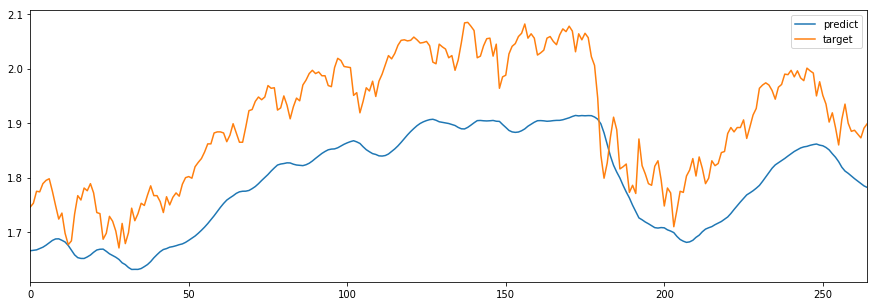

In [117]:
model.load_weights(best_model_path())    
predicted = model.predict(X_test)
for i in range(3):
    print("predicted[i]", predicted[i])
    print("Y_test[i]", Y_test[i])

dataf =  pd.DataFrame(predicted[200:])
dataf.columns = ["predict"]
dataf["target"] = Y_test[200:]
dataf.plot(figsize=(15, 5))
show()    


Okay so, this result doesn't match a result from 2, I think.
The prediction fits the target value very well.
How about mixing up up/down in Y?

In [204]:
# we use last 200 days data
nb_prev = 200 # to be 200

X = []
Y = []

for i in range(len(prices)-nb_prev):
    X.append(prices.iloc[i:i+nb_prev].as_matrix())
    mixed_Y_i = np.array([prices.iloc[i+nb_prev], 1 if prices.iloc[i+nb_prev] - prices.iloc[i+nb_prev - 1] > 0 else 0])
    Y.append(mixed_Y_i)
    if i == 0:
        print(mixed_Y_i)

X = np.array(X).reshape(-1, nb_prev, 1)
print("X.shape", X.shape)
Y = np.array(Y)
#Y = np.array(Y).reshape(-1, 2)
print("Y.shape", Y.shape)

[ 1.795  1.   ]
X.shape (4653, 200, 1)
Y.shape (4653, 2)


In [205]:
# randomly split the data
test_size = 0.1
nb_train = int(round(len(X) * (1 - test_size)))
print("test_data_size", len(X) - nb_train)
shuffle = False

if shuffle:
    indices = np.random.permutation(X.shape[0])
    training_idx, test_idx = indices[:nb_train], indices[nb_train:]
    X_train, X_test = X[training_idx,:], X[test_idx,:]
    Y_train, Y_test = Y[training_idx,:], Y[test_idx,:]
else:
    X_train, X_test = X[:nb_train], X[nb_train:]
    Y_train, Y_test = Y[:nb_train], Y[nb_train:]    

print(X_train.shape)
print(Y_train.shape)
print("X_test.shape", X_test.shape)
print("Y_test.shape", Y_test.shape)

test_data_size 465
(4188, 200, 1)
(4188, 2)
X_test.shape (465, 200, 1)
Y_test.shape (465, 2)


In [206]:
in_out_neurons = 1
hidden_neurons = 300
length_of_sequences = nb_prev
model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, nb_prev, in_out_neurons), return_sequences=False))  
#model.add(Dense(10, init='uniform'))
#model.add(Activation('tanh'))
model.add(Dense(2))  
model.add(Activation("linear"))  
#    model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.compile(loss="mean_squared_error", optimizer="adam")

print(model.summary)


<bound method Container.summary of <keras.models.Sequential object at 0x1377bf198>>


In [ ]:
version = 555
## train
os.makedirs(weights_dir, exist_ok=True)
filepath = weights_dir + "/{loss:.4f}"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
print(X_train.shape)
print(Y_train.shape)
model.fit(X_train, Y_train, batch_size=600, nb_epoch=20, validation_split=0.05, callbacks=callbacks_list)


(4188, 200, 1)
(4188, 2)
Train on 3978 samples, validate on 210 samples
Epoch 1/20
3978/3978 [==============================] - 118s - loss: 0.2806 - val_loss: 0.1655
Epoch 2/20
3978/3978 [==============================] - 113s - loss: 0.1453 - val_loss: 0.1353
Epoch 3/20
3978/3978 [==============================] - 107s - loss: 0.1335 - val_loss: 0.1311
Epoch 4/20
3978/3978 [==============================] - 113s - loss: 0.1296 - val_loss: 0.1290
Epoch 5/20
3978/3978 [==============================] - 109s - loss: 0.1272 - val_loss: 0.1282
Epoch 6/20
3978/3978 [==============================] - 110s - loss: 0.1269 - val_loss: 0.1260
Epoch 7/20
3978/3978 [==============================] - 117s - loss: 0.1261 - val_loss: 0.1261
Epoch 8/20
3978/3978 [==============================] - 108s - loss: 0.1259 - val_loss: 0.1259
Epoch 9/20
3978/3978 [==============================] - 109s - loss: 0.1258 - val_loss: 0.1259
Epoch 10/20
3978/3978 [==============================] - 114s - loss: 0.1

In [200]:
#model.load_weights(best_model_path())    
predicted = model.predict(X_test)
print(predicted.shape)


(480, 2)


In [201]:
prices_prediction = predicted[:,0]
up_down_prediction = predicted[:,1]
print(up_down_prediction)


[ 0.53842837  0.53805196  0.5376364   0.53718078  0.53689051  0.53651875
  0.53623021  0.53609622  0.53614444  0.53652275  0.53675687  0.53643215
  0.53633708  0.53624868  0.53615499  0.53650701  0.53647459  0.53636873
  0.53597254  0.5356167   0.5353424   0.53560042  0.53620076  0.53696406
  0.53733391  0.53773397  0.5386169   0.53911394  0.539657    0.54011822
  0.54051131  0.54093778  0.54135466  0.54199171  0.54221392  0.54233742
  0.54219967  0.54194462  0.54197705  0.54188263  0.54213053  0.54218566
  0.54249424  0.54243314  0.54216242  0.54151589  0.54118329  0.54057121
  0.54022491  0.5400027   0.53975999  0.53968841  0.53969991  0.54004598
  0.54035854  0.54065901  0.54096609  0.54148453  0.54208905  0.54256529
  0.54270238  0.54273415  0.54258746  0.54233158  0.54162955  0.5411213
  0.54067612  0.54040003  0.54055238  0.54066831  0.5409264   0.54121602
  0.54155779  0.54188275  0.54193926  0.54185563  0.54212469  0.54223323
  0.54221606  0.54224831  0.54203057  0.54189122  0.

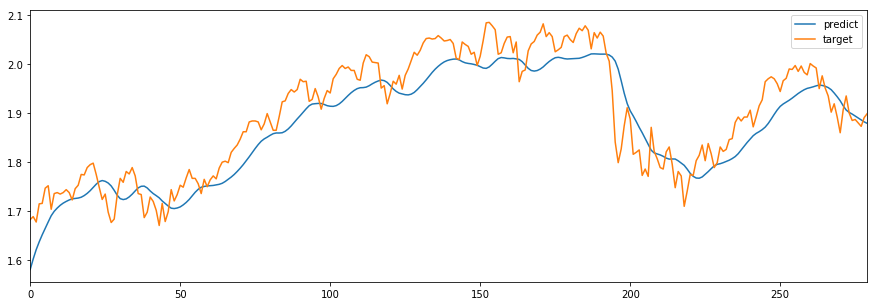

In [202]:
dataf =  pd.DataFrame(prices_prediction[200:])
dataf.columns = ["predict"]
dataf["target"] = Y_test[:,0][200:]
dataf.plot(figsize=(15, 5))
show()    

In [203]:
# accuracy

# predicted is (N, 2) 2 is two classes
# convert it to (N, 1) where 1 is class label 0 or 1
predicted_classes = np.around(up_down_prediction)
target_classes = Y_test[:,1]
print(predicted_classes)
print(target_classes)


# how many samples match target
correct = np.sum(predicted_classes == target_classes)

# accuracy = number correct / total number
accuracy = correct / (len(Y_test) * 1.0)
print("accuracy = ", accuracy)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

## Thouhts
- price values fit well as previous one did
- up/down is not very good at all
- Why?
  - "linear" activation is not very good?
  - non-linear classfication